# AlexNet / Cifar-10

AlexNet architektūra skiriasi nuo LeNet-5 pradedant nuo įvesties matmenų kurie yra 224x224x3 ir daugiau kanalų po kiekvienos kovoliucijos ir labai dideliais `fc` sluoksniais ir 1000 skirtingų kategorijų etikečių. Šio tinklo architektrūra nežymiai modifkuosime nes treniruosime ne su ImageNet o su CIFAR 10 duomenų rinkinių kurie yra mažesni ir pačių duomenų yra mažiau.   

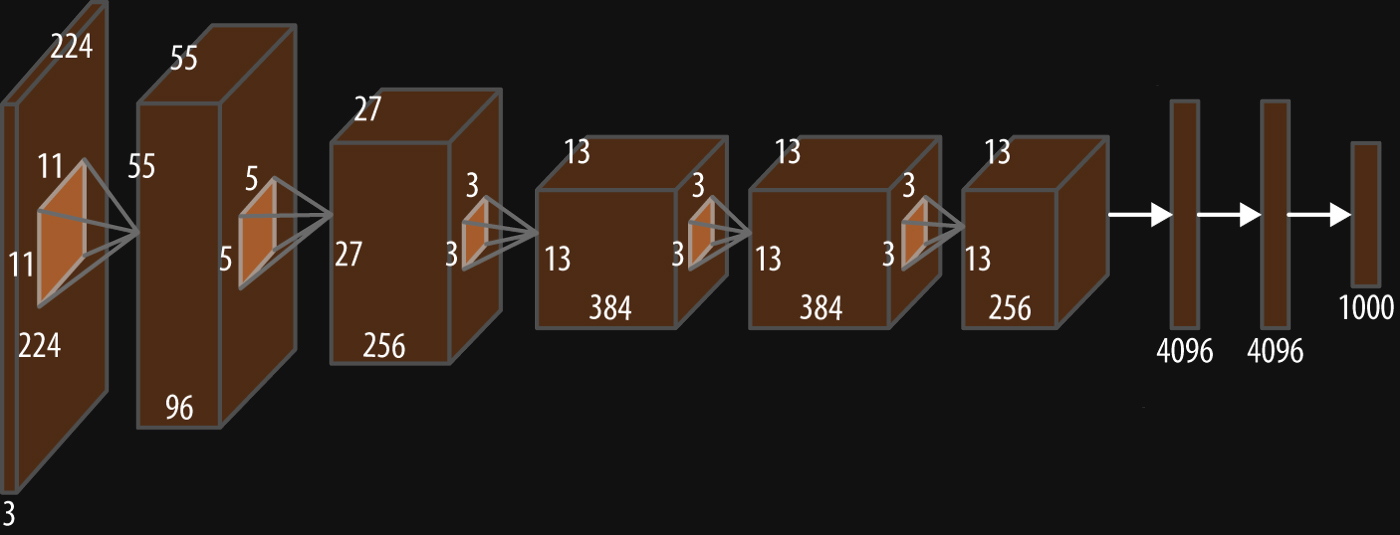

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [ ]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Nustatymai ir duomenų rinkinys

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE  = 256
NUM_EPOCHS  = 200
DEVICE      = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)

CIFAR 10 duomenys yra 32x32 bet mes juos didiname iki 70x70 kaš išvengti matmenų neatikmens algebros operacijose, ir prastų rezultatų nes dirbant su orginalaus dydžio atvaizdas galutiniuose konvoliucijos sluoksnuose savybių žemėlapiai bus nenaudingai maži. Ir tai pat kad padėti išvengti perteklinio prisiderinimo mes pridedame papildoma transformacijos operacija [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html) kuri sukels nedideles perturbacijas. Kur atliks atsitiktini vaizdo apkirpimo (ang. crop) operacija iki 64x64.
Rekomenduoju atlikti eksperimentus tai pat su [ColorJitter](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) ir [RandomRotation](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html).
Tuomet konvertuojame duomenys į tensorių ir atliekame visų trijų (RGB) kanalų normalizacija. Atkreipkite dėmėsį kad atsitiktinio apkirpimo operaciją darome tiktai treniravimo duomenų rinkiniui. Testavimo rinkiniui kuris bus naudojamas imituoti tikrą modelio veiklą mes atliekame tik [CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html). 

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## Modelis

In [ ]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            # 1 sluoksnis
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # 2 sluoksnis
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            # 3 sluoksnis
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            # 4 sluoksnis
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            # 5 sluoksnis
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # AdaptiveAvgPool2D atliks suaibės redukcija veikia taip kad nesvarbu kokia bus įvestis
        # suvidrukinta išvestis bus sugeneruota pagal nurodytus matmenys.
        # taip mes užtikriname prognozuojama duomenų transfortavimą iš savybių ištraukimo į fc sluoksnį
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [ ]:
model = AlexNet(num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()